In [1]:
from homework_code.dataset.quora_dataset import QuoraDataset, collate
from homework_code.dataset.utils import convert_data_to_tuples, text_to_wordlist
from homework_code.dataset.language import Language
from homework_code.model.network import EmbeddingLSTMNet, SiameseNetwork
from homework_code.model.model_trainer import ModelTrainer
from homework_code.model.utils import create_pretrained_weights, plotConfusionMatrix, save_model
import os
import pandas as pd
import numpy as np
import wandb

import torch
import torch.nn as nn

from torch.utils.data import DataLoader, SubsetRandomSampler

%load_ext autoreload

%autoreload 2

#### Global varibles

In [2]:
# Root and directory paths 
ROOT_PATH = os.getcwd()
DATA_FOLDER_PATH = ROOT_PATH + '/data'
GOOGLE_EMBEDDING_FOLDER_PATH = DATA_FOLDER_PATH + '/google embedding'
GOOGLE_EMBEDDING = GOOGLE_EMBEDDING_FOLDER_PATH + '/GoogleNews-vectors-negative300.bin'
MODEL_FOLDER_PATH = ROOT_PATH 
# important paths 
DATASET_FILE_PATH = DATA_FOLDER_PATH + '/mini_quora_dataset_30_50_50k.csv'
EMBEDDING_PATH = GOOGLE_EMBEDDING_FOLDER_PATH + GOOGLE_EMBEDDING

# general variables
EMBEDDING_REQUIRES_GRAD = False
NUM_LAYERS = 1

#### Hyperparameters 

In [3]:
# hyperperameters 

hparams = {
    'threshold': torch.Tensor([0.5]),
    'learning_rate': 1e-03,
    'epoch': 50,
    'batch_size': 32,
    'hidden_dim': 100,
    'embedding_dim': 300,
    'dropout': 0.0,
    'remove_stopwords': True,
    'stem_words': True
}

#### Load File

In [4]:
df = pd.read_csv(DATASET_FILE_PATH)

In [5]:
q_pair, labels = convert_data_to_tuples(df, hparams['remove_stopwords'], hparams['stem_words'])


Question Pairs:  49998


#### Crate Language

In [6]:
language = Language()
for data in [q_pair]:
    for question_pair in data:
        q1 = question_pair[0]
        q2 = question_pair[1]
        language.addSentence(q1)
        language.addSentence(q2)

#### Load datset

In [7]:
quora_dataset = QuoraDataset(q_pair, language.word2index, labels)

In [8]:
for sample in quora_dataset:
    print('question 1:', sample['q1'])
    print('question 2:', sample['q2'])
    print('tokens  q1:', sample['q1_token'])
    print('tokens  q2:', sample['q2_token'])
    print('labels    :', sample['labels'])
    break

question 1: differ way make money fast
question 2: fast way make money
tokens  q1: [1, 2, 3, 4, 5]
tokens  q2: [5, 2, 3, 4]
labels    : 1


#### Dataloader

In [9]:
"""train_split = 0.6
val_split = 0.2
test_split = 0.2

dataset_size = len(quora_dataset)
indices = list(range(dataset_size))

split_train = int(train_split*dataset_size)
split_val = split_train + int(val_split*dataset_size)

shuffle_dataset = True
random_seed = 46

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices, test_indices = indices[:split_train], indices[split_train:split_val], indices[split_val:]

assert len(train_indices) + len(val_indices) + len(test_indices) == dataset_size

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_dataloader = torch.utils.data.DataLoader(quora_dataset, batch_size=hparams['batch_size'], sampler=train_sampler, collate_fn=collate)
val_dataloader = torch.utils.data.DataLoader(quora_dataset, batch_size=hparams['batch_size'], sampler=val_sampler, collate_fn=collate)
test_dataloader = torch.utils.data.DataLoader(quora_dataset, batch_size=hparams['batch_size'], sampler=test_sampler, collate_fn=collate)

test_predict_dataloader = torch.utils.data.DataLoader(quora_dataset, batch_size=1, sampler=test_sampler, collate_fn=collate)

print('Training Set Size {}, Validation Set Size {}, Test Set Size {}'.format(len(train_indices), len(val_indices), len(test_indices)))
"""

"train_split = 0.6\nval_split = 0.2\ntest_split = 0.2\n\ndataset_size = len(quora_dataset)\nindices = list(range(dataset_size))\n\nsplit_train = int(train_split*dataset_size)\nsplit_val = split_train + int(val_split*dataset_size)\n\nshuffle_dataset = True\nrandom_seed = 46\n\nif shuffle_dataset :\n    np.random.seed(random_seed)\n    np.random.shuffle(indices)\ntrain_indices, val_indices, test_indices = indices[:split_train], indices[split_train:split_val], indices[split_val:]\n\nassert len(train_indices) + len(val_indices) + len(test_indices) == dataset_size\n\ntrain_sampler = SubsetRandomSampler(train_indices)\nval_sampler = SubsetRandomSampler(val_indices)\ntest_sampler = SubsetRandomSampler(test_indices)\n\ntrain_dataloader = torch.utils.data.DataLoader(quora_dataset, batch_size=hparams['batch_size'], sampler=train_sampler, collate_fn=collate)\nval_dataloader = torch.utils.data.DataLoader(quora_dataset, batch_size=hparams['batch_size'], sampler=val_sampler, collate_fn=collate)\ntes

In [10]:
train_split = 0.8
val_split = 0.2

dataset_size = len(quora_dataset)
indices = list(range(dataset_size))

split_train = int(train_split*dataset_size)

shuffle_dataset = True
random_seed = 46

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[:split_train], indices[split_train:]

assert len(train_indices) + len(val_indices) == dataset_size

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
#test_sampler = SubsetRandomSampler(test_indices)

train_dataloader = torch.utils.data.DataLoader(quora_dataset, batch_size=hparams['batch_size'], sampler=train_sampler, collate_fn=collate)
val_dataloader = torch.utils.data.DataLoader(quora_dataset, batch_size=hparams['batch_size'], sampler=val_sampler, collate_fn=collate)
#test_dataloader = torch.utils.data.DataLoader(quora_dataset, batch_size=hparams['batch_size'], sampler=test_sampler, collate_fn=collate)

#test_predict_dataloader = torch.utils.data.DataLoader(quora_dataset, batch_size=1, sampler=test_sampler, collate_fn=collate)

print('Training Set Size {}, Validation Set Size {},'.format(len(train_indices), len(val_indices)))


Training Set Size 39998, Validation Set Size 10000,


#### Model set up 

In [11]:
# create pretrained weights 
# skip this step because time consuming and might make cpu brake
# instead import the pretrained_weights.pt

#pretrained_weights = create_pretrained_weights(GOOGLE_EMBEDDING, EMBEDDING_DIMENSION, language)
#pretrained_weights

In [12]:
#torch.save(pretrained_weights, 'pretrained_weights.pt')

In [13]:
pre_weights = torch.load('pretrained_weights.pt')
pre_weights

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1396, -0.0062,  0.2148,  ...,  0.0571,  0.0996, -0.2344],
        [-0.0967, -0.0264,  0.0903,  ..., -0.0197,  0.2139,  0.1367],
        ...,
        [-0.2100, -0.3711, -0.1211,  ..., -0.0066,  0.0742, -0.0233],
        [-0.1348, -0.0233, -0.0640,  ...,  0.2051,  0.1226, -0.1250],
        [-0.0381, -0.1445,  0.1426,  ...,  0.0216,  0.0688,  0.0171]])

In [14]:
# embedding net
embedding_net2 = EmbeddingLSTMNet(
    hparams['embedding_dim'],
    hparams['hidden_dim'],
    NUM_LAYERS,
    EMBEDDING_REQUIRES_GRAD,
    pre_weights,
    hparams['dropout'],
)

# siamese model
model2 = SiameseNetwork(embedding_net2)


#### Train

In [15]:
trainer = ModelTrainer(
    model2, 
    hparams, 
    train_dataloader, 
    val_dataloader,
    train_indices, 
    val_indices,
)

/Users/Maxi/opt/anaconda3/lib/python3.7/site-packages/cryptography/hazmat/backends/openssl/x509.py:18: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  utils.DeprecatedIn35,
wandb: Currently logged in as: maxifor (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [16]:
trainer.fit() 

Epoch [1/50]  Training: 100%|██████████| 1250/1250 [00:28<00:00, 43.70batch/s, train_acc=65.625 %, train_loss=0.212]


Epoch [1/50]: val_loss: 0.20400710703846744 val_acc: 70.6 %


Epoch [2/50]  Training: 100%|██████████| 1250/1250 [00:28<00:00, 44.07batch/s, train_acc=68.75 %, train_loss=0.186] 


Epoch [2/50]: val_loss: 0.19483323609486175 val_acc: 71.63000000000001 %


Epoch [3/50]  Training: 100%|██████████| 1250/1250 [00:27<00:00, 44.71batch/s, train_acc=75.0 %, train_loss=0.17]  


Epoch [3/50]: val_loss: 0.18908682284644618 val_acc: 72.54 %


Epoch [4/50]  Training: 100%|██████████| 1250/1250 [00:29<00:00, 42.62batch/s, train_acc=71.875 %, train_loss=0.158]


Epoch [4/50]: val_loss: 0.1879979176595569 val_acc: 72.7 %


Epoch [5/50]  Training: 100%|██████████| 1250/1250 [00:28<00:00, 43.14batch/s, train_acc=87.5 %, train_loss=0.146]  


Epoch [5/50]: val_loss: 0.18442476769320118 val_acc: 73.68 %


Epoch [6/50]  Training: 100%|██████████| 1250/1250 [00:27<00:00, 45.81batch/s, train_acc=78.125 %, train_loss=0.134]


Epoch [6/50]: val_loss: 0.1839403535325687 val_acc: 73.83 %


Epoch [7/50]  Training: 100%|██████████| 1250/1250 [00:27<00:00, 46.02batch/s, train_acc=78.125 %, train_loss=0.125]


Epoch [7/50]: val_loss: 0.18193673529325963 val_acc: 74.35000000000001 %


Epoch [8/50]  Training: 100%|██████████| 1250/1250 [00:27<00:00, 45.42batch/s, train_acc=81.25 %, train_loss=0.116] 


Epoch [8/50]: val_loss: 0.18145526845615131 val_acc: 74.33999999999999 %


Epoch [9/50]  Training: 100%|██████████| 1250/1250 [00:27<00:00, 45.88batch/s, train_acc=84.375 %, train_loss=0.108]


Epoch [9/50]: val_loss: 0.18165702022873936 val_acc: 74.17 %


Epoch [10/50]  Training: 100%|██████████| 1250/1250 [00:27<00:00, 45.87batch/s, train_acc=90.625 %, train_loss=0.101]


Epoch [10/50]: val_loss: 0.18192176448222927 val_acc: 74.4 %


Epoch [11/50]  Training: 100%|██████████| 1250/1250 [00:27<00:00, 45.97batch/s, train_acc=84.375 %, train_loss=0.094] 


Epoch [11/50]: val_loss: 0.1809529130832075 val_acc: 74.17 %


Epoch [12/50]  Training: 100%|██████████| 1250/1250 [00:28<00:00, 44.40batch/s, train_acc=90.625 %, train_loss=0.088]


Epoch [12/50]: val_loss: 0.18194698828001754 val_acc: 74.64 %


Epoch [13/50]  Training: 100%|██████████| 1250/1250 [00:28<00:00, 43.73batch/s, train_acc=96.875 %, train_loss=0.0831]


Epoch [13/50]: val_loss: 0.18191025770319919 val_acc: 74.85000000000001 %


Epoch [14/50]  Training: 100%|██████████| 1250/1250 [00:28<00:00, 44.48batch/s, train_acc=90.625 %, train_loss=0.0786]


Epoch [14/50]: val_loss: 0.18305950014355082 val_acc: 74.55000000000001 %


Epoch [15/50]  Training: 100%|██████████| 1250/1250 [00:27<00:00, 45.90batch/s, train_acc=87.5 %, train_loss=0.075]  


Epoch [15/50]: val_loss: 0.1836660217029599 val_acc: 74.44 %


Epoch [16/50]  Training: 100%|██████████| 1250/1250 [00:27<00:00, 46.02batch/s, train_acc=93.75 %, train_loss=0.0709] 


Epoch [16/50]: val_loss: 0.1831562534783976 val_acc: 74.82 %


Epoch [17/50]  Training: 100%|██████████| 1250/1250 [00:27<00:00, 46.09batch/s, train_acc=100.0 %, train_loss=0.0679] 


Epoch [17/50]: val_loss: 0.18448601420314167 val_acc: 74.72999999999999 %


Epoch [18/50]  Training: 100%|██████████| 1250/1250 [00:27<00:00, 45.94batch/s, train_acc=100.0 %, train_loss=0.0652] 


Epoch [18/50]: val_loss: 0.18459893213198209 val_acc: 74.83 %


Epoch [19/50]  Training: 100%|██████████| 1250/1250 [00:27<00:00, 45.92batch/s, train_acc=100.0 %, train_loss=0.0625]


Epoch [19/50]: val_loss: 0.18528154609016717 val_acc: 74.53 %


Epoch [20/50]  Training: 100%|██████████| 1250/1250 [00:27<00:00, 45.15batch/s, train_acc=90.625 %, train_loss=0.0601]


Epoch [20/50]: val_loss: 0.18571181904774503 val_acc: 74.56 %


Epoch [21/50]  Training: 100%|██████████| 1250/1250 [00:28<00:00, 43.88batch/s, train_acc=93.75 %, train_loss=0.058]  


Epoch [21/50]: val_loss: 0.1862070740887913 val_acc: 74.59 %


Epoch [22/50]  Training: 100%|██████████| 1250/1250 [00:27<00:00, 45.17batch/s, train_acc=100.0 %, train_loss=0.0565] 


Epoch [22/50]: val_loss: 0.18605662694278235 val_acc: 74.67 %


Epoch [23/50]  Training: 100%|██████████| 1250/1250 [00:31<00:00, 39.76batch/s, train_acc=93.75 %, train_loss=0.0548]


Epoch [23/50]: val_loss: 0.1870792044427829 val_acc: 74.62 %


Epoch [24/50]  Training: 100%|██████████| 1250/1250 [00:27<00:00, 46.23batch/s, train_acc=96.875 %, train_loss=0.0533]


Epoch [24/50]: val_loss: 0.18664021443682738 val_acc: 74.47 %


Epoch [25/50]  Training: 100%|██████████| 1250/1250 [00:26<00:00, 46.71batch/s, train_acc=93.75 %, train_loss=0.0521] 


Epoch [25/50]: val_loss: 0.1869813036709167 val_acc: 74.57000000000001 %


Epoch [26/50]  Training: 100%|██████████| 1250/1250 [00:27<00:00, 46.10batch/s, train_acc=96.875 %, train_loss=0.0508]


Epoch [26/50]: val_loss: 0.1875325978492586 val_acc: 74.63 %


Epoch [27/50]  Training: 100%|██████████| 1250/1250 [00:27<00:00, 46.06batch/s, train_acc=96.875 %, train_loss=0.0496]


Epoch [27/50]: val_loss: 0.18768495568833032 val_acc: 74.56 %


Epoch [28/50]  Training: 100%|██████████| 1250/1250 [00:27<00:00, 46.25batch/s, train_acc=93.75 %, train_loss=0.0486]


Epoch [28/50]: val_loss: 0.1880897483505761 val_acc: 74.57000000000001 %


Epoch [29/50]  Training: 100%|██████████| 1250/1250 [00:26<00:00, 47.10batch/s, train_acc=93.75 %, train_loss=0.0478] 


Epoch [29/50]: val_loss: 0.1885981738400726 val_acc: 74.64 %


Epoch [30/50]  Training: 100%|██████████| 1250/1250 [00:26<00:00, 46.59batch/s, train_acc=90.625 %, train_loss=0.0472]


Epoch [30/50]: val_loss: 0.18846220549303122 val_acc: 74.66000000000001 %


Epoch [31/50]  Training: 100%|██████████| 1250/1250 [00:26<00:00, 46.91batch/s, train_acc=96.875 %, train_loss=0.0461]


Epoch [31/50]: val_loss: 0.1886492096625578 val_acc: 74.64 %


Epoch [32/50]  Training: 100%|██████████| 1250/1250 [00:27<00:00, 46.28batch/s, train_acc=100.0 %, train_loss=0.0455] 


Epoch [32/50]: val_loss: 0.1888665076785575 val_acc: 74.6 %


Epoch [33/50]  Training: 100%|██████████| 1250/1250 [00:26<00:00, 46.74batch/s, train_acc=90.625 %, train_loss=0.0451]


Epoch [33/50]: val_loss: 0.18894739934621146 val_acc: 74.7 %


Epoch [34/50]  Training: 100%|██████████| 1250/1250 [00:27<00:00, 46.27batch/s, train_acc=90.625 %, train_loss=0.0444]


Epoch [34/50]: val_loss: 0.18903043691199808 val_acc: 74.56 %


Epoch [35/50]  Training: 100%|██████████| 1250/1250 [00:26<00:00, 46.63batch/s, train_acc=100.0 %, train_loss=0.0443]


Epoch [35/50]: val_loss: 0.18929762081406748 val_acc: 74.82 %


Epoch [36/50]  Training: 100%|██████████| 1250/1250 [00:26<00:00, 46.91batch/s, train_acc=100.0 %, train_loss=0.0436] 


Epoch [36/50]: val_loss: 0.1894623386545684 val_acc: 74.72 %


Epoch [37/50]  Training: 100%|██████████| 1250/1250 [00:27<00:00, 45.85batch/s, train_acc=96.875 %, train_loss=0.0435]


Epoch [37/50]: val_loss: 0.18967277434068366 val_acc: 74.67 %


Epoch [38/50]  Training: 100%|██████████| 1250/1250 [00:26<00:00, 47.01batch/s, train_acc=93.75 %, train_loss=0.043]  


Epoch [38/50]: val_loss: 0.18965415304270797 val_acc: 74.76 %


Epoch [39/50]  Training: 100%|██████████| 1250/1250 [00:26<00:00, 46.45batch/s, train_acc=100.0 %, train_loss=0.0425] 


Epoch [39/50]: val_loss: 0.18974381392470563 val_acc: 74.74 %


Epoch [40/50]  Training: 100%|██████████| 1250/1250 [00:27<00:00, 45.72batch/s, train_acc=96.875 %, train_loss=0.0424]


Epoch [40/50]: val_loss: 0.18969688067040125 val_acc: 74.67 %


Epoch [41/50]  Training: 100%|██████████| 1250/1250 [00:26<00:00, 46.81batch/s, train_acc=87.5 %, train_loss=0.0424]  


Epoch [41/50]: val_loss: 0.18993531943510134 val_acc: 74.7 %


Epoch [42/50]  Training: 100%|██████████| 1250/1250 [00:27<00:00, 46.09batch/s, train_acc=96.875 %, train_loss=0.042]


Epoch [42/50]: val_loss: 0.190223820233783 val_acc: 74.66000000000001 %


Epoch [43/50]  Training: 100%|██████████| 1250/1250 [00:26<00:00, 46.43batch/s, train_acc=96.875 %, train_loss=0.0418]


Epoch [43/50]: val_loss: 0.18997877312544437 val_acc: 74.79 %


Epoch [44/50]  Training: 100%|██████████| 1250/1250 [00:26<00:00, 46.39batch/s, train_acc=93.75 %, train_loss=0.0418] 


Epoch [44/50]: val_loss: 0.1901494737940665 val_acc: 74.77000000000001 %


Epoch [45/50]  Training: 100%|██████████| 1250/1250 [00:26<00:00, 46.66batch/s, train_acc=100.0 %, train_loss=0.0412]


Epoch [45/50]: val_loss: 0.19054151931033728 val_acc: 74.74 %


Epoch [46/50]  Training: 100%|██████████| 1250/1250 [00:27<00:00, 46.16batch/s, train_acc=93.75 %, train_loss=0.0414]


Epoch [46/50]: val_loss: 0.1902932722966511 val_acc: 74.71 %


Epoch [47/50]  Training: 100%|██████████| 1250/1250 [00:26<00:00, 46.57batch/s, train_acc=96.875 %, train_loss=0.0415]


Epoch [47/50]: val_loss: 0.19052545447795155 val_acc: 74.68 %


Epoch [48/50]  Training: 100%|██████████| 1250/1250 [00:26<00:00, 46.74batch/s, train_acc=96.875 %, train_loss=0.0411]


Epoch [48/50]: val_loss: 0.19042238935875816 val_acc: 74.78 %


Epoch [49/50]  Training: 100%|██████████| 1250/1250 [00:26<00:00, 46.35batch/s, train_acc=96.875 %, train_loss=0.041] 


Epoch [49/50]: val_loss: 0.1904678470410478 val_acc: 74.68 %


Epoch [50/50]  Training: 100%|██████████| 1250/1250 [00:26<00:00, 46.50batch/s, train_acc=93.75 %, train_loss=0.0408] 


Epoch [50/50]: val_loss: 0.19042065905067868 val_acc: 74.72999999999999 %


train_acc,▁▂▃▄▅▅▅▆▆▇▇▇▇▇▇█████████████████████████
train_loss,█▇▆▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▃▄▄▆▇▇▇▇██████▇███▇████████████████████
val_loss,█▅▃▃▂▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄
train_acc,96.50733
train_loss,0.04092
val_acc,74.73
val_loss,0.19042


#### Testing model 

- - - Model Performance - - -

Model Accuracy:  74.72999999999999
Correct predictions: 7473, Incorret predictions: 2527



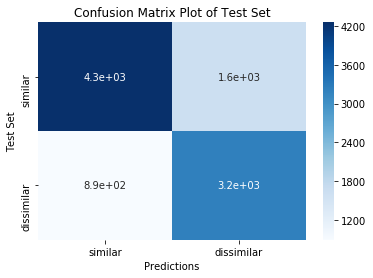

TP: 4255
FP: 894
FN: 1633
TN: 3218

Percision Score: 0.663368377654092
Recall Score: 0.7825875486381323
F1 Score: 0.7180631484993864


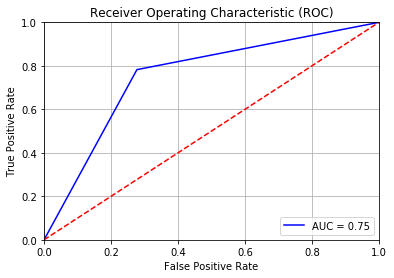

In [17]:
trainer.test()

#### Store Model

In [18]:
# filename = "model.pt"
# path = ROOT_PATH
#save_model(model, path)

In [82]:
#### check out random sample from training data

In [83]:
ind = np.random.choice(len(train_dataloader))
test_sample_train = dict()
for idx, batch in enumerate(train_dataloader):
    if idx == ind:
        test_sample_train['q1_text'] = [batch['q1_text'][0]]
        test_sample_train['q2_text'] = [batch['q2_text'][0]]
        test_sample_train['q1_token'] = [batch['q1_token'][0]]
        test_sample_train['q2_token'] = [batch['q2_token'][0]]
        test_sample_train['q1_lengths'] = [batch['q1_lengths'][0]]
        test_sample_train['q2_lengths'] = [batch['q2_lengths'][0]]
        test_sample_train['labels'] = [batch['labels'][0]]
        

In [84]:
trainer.predict(test_sample_train)

question 1: ['get english better']
question 2: ['speak english like celebr']
tokens  q1: [[93, 8, 400]]
tokens  q2: [[1021, 8, 114, 923]]


Model predicts 1.0 --> Actual value 1.0
Model prediction is correct :)

The questions ['get english better'] and ['speak english like celebr'] are similar!


In [85]:
#### checkout random sample from validatin data

In [86]:
ind = np.random.choice(len(val_dataloader))

test_sample_val = dict()
for idx, batch in enumerate(val_dataloader):
    if idx == ind:
        test_sample_val['q1_text'] = [batch['q1_text'][0]]
        test_sample_val['q2_text'] = [batch['q2_text'][0]]
        test_sample_val['q1_token'] = [batch['q1_token'][0]]
        test_sample_val['q2_token'] = [batch['q2_token'][0]]
        test_sample_val['q1_lengths'] = [batch['q1_lengths'][0]]
        test_sample_val['q2_lengths'] = [batch['q2_lengths'][0]]
        test_sample_val['labels'] = [batch['labels'][0]]

In [87]:
trainer.predict(test_sample_val)

question 1: ['whatsapp read messag']
question 2: ['check whatsapp messag onlin']
tokens  q1: [[1193, 1128, 211]]
tokens  q2: [[988, 1193, 211, 130]]


Model predicts 0.0 --> Actual value 0.0
Model prediction is correct :)

The questions ['whatsapp read messag'] and ['check whatsapp messag onlin'] are dissimilar!


#### Predict from Custom input

In [19]:
default = True  # set to False to create your own inputs
similar = False  # select False to dispaly dissimlar example

if default:
    if similar:
        q1 = ['Is it cold today?']
        q2 = ['Will it be cold today?']
        label = [1.0]
    else:
        q1 = ['Will I pass the final?']
        q2 = ['What will I have for dinner tonight?']
        label = [0.0]
else:
    q1 = input(r'Enter your 1^st question: ')
    q2 = input(r'Enter your 2^nd question: ')
    label = input('label: ') # 0 for dissimilar, 1 for similar 
    q1 = [q1]
    q2 = [q2]
    label = [label]

In [20]:
# prepair custom input
# create df
df_own = pd.DataFrame(list(zip(q1, q2, label)), columns=['question1', 'question2', 'is_duplicate'])
# prepare data 
q_pair_own, label = convert_data_to_tuples(df_own, hparams['remove_stopwords'], hparams['stem_words'])
q_pair_own

Question Pairs:  1


[('pass final', 'dinner tonight')]

In [21]:
# create dataset 
own_dataset = QuoraDataset(q_pair_own, language.word2index, label)

# create dataloader
predict_dataloader = torch.utils.data.DataLoader(own_dataset, batch_size=1, collate_fn=collate)

In [22]:
for sample in predict_dataloader:
    test_sample = sample

In [23]:
trainer.predict(test_sample)

question 1: ['pass final']
question 2: ['dinner tonight']
tokens  q1: [[1243, 1086]]
tokens  q2: [[3535, 8789]]


Model predicts 0.0 --> Actual value 0.0
Model prediction is correct :)

The questions ['pass final'] and ['dinner tonight'] are dissimilar!


In [24]:
model2.parameters

<bound method Module.parameters of SiameseNetwork(
  (embedding): EmbeddingLSTMNet(
    (dropout): Dropout(p=0.0, inplace=False)
    (lstm): LSTM(300, 100, batch_first=True)
    (fc1): Linear(in_features=100, out_features=100, bias=True)
    (fc): Linear(in_features=100, out_features=100, bias=True)
    (relu): ReLU()
    (embedding): Embedding(23020, 300)
  )
)>

In [88]:
from sklearn.manifold import TSNE

In [91]:
tsne = TSNE(random_state=1, n_iter=15000, metric="cosine")



In [97]:
embs = tsne.fit_transform(pre_weights.detach().numpy())

KeyboardInterrupt: 

In [95]:
pre_weights.detach().numpy().shape

(23020, 300)